
## Data Description

The analysis is performed over two datasets one contains posts from reddits users and a "external dataset" containing U.S. Census Bureau data.

#### Reddit Data
The reddit dataset contains posts and its metadata from January 2021 to March 2023. This analysis will focus in the next threads: 'washingtondc', 'Seattle', 'Atlanta' and 'nyc' for each of the top previously mentioned cities.

#### Census Data

A tell-tale sign of “gentrification” in an area is rising rent prices. In order for us to understand what time period gentrification began in these cities, we pulled U.S. Census Bureau data on rent prices within these cities over the past few years. Although it is natural for rent prices to naturally increase over time given inflation trends, gentrification can cause rent prices to abnormally increase. This typically results in long-time residents no longer being able to afford to live in these areas. Being able to see when these rent spikes occured may give us more insight as to where we’d expect Reddit Posts to change in sentiment, or even in topics, due to the change of residents.

## Exploration of Reddit data 

We start by exploring the dataset that contains the filtered threads:


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import nltk
import json
import requests
import os
from pathlib import Path
import re
import plotly.graph_objects as go
import geopandas as gpd

from pathlib import Path

reddit_df = pd.read_parquet("reddit_df.parquet")

print("Shape of the dataframe:",reddit_df.shape)
print("Columns on the dataframe:", [i for i in reddit_df.columns])
print("Selected threads on the dataframe:", reddit_df.subreddit.unique())

Shape of the dataframe: (217394, 68)
Columns on the dataframe: ['adserver_click_url', 'adserver_imp_pixel', 'archived', 'author', 'author_cakeday', 'author_flair_css_class', 'author_flair_text', 'author_id', 'brand_safe', 'contest_mode', 'created_utc', 'crosspost_parent', 'crosspost_parent_list', 'disable_comments', 'distinguished', 'domain', 'domain_override', 'edited', 'embed_type', 'embed_url', 'gilded', 'hidden', 'hide_score', 'href_url', 'id', 'imp_pixel', 'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video', 'link_flair_css_class', 'link_flair_text', 'locked', 'media', 'media_embed', 'mobile_ad_url', 'num_comments', 'num_crossposts', 'original_link', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'post_hint', 'preview', 'promoted', 'promoted_by', 'promoted_display_name', 'promoted_url', 'retrieved_on', 'score', 'secure_media', 'secure_media_embed', 'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id', 'suggested_sort', 'third_party_trackers'

### Data cleaning 

First, we wanted to explore what each of the columns from the Reddit submission data contained. We went through each of them to see what percentage of those were populated, and dropped any columns that were more than 90% null after confirming that these columns did not contain any information that we wanted to use within our analysis.

There are a few columns containing numerical data that we are very interested for our analysis - particularly `num_comments` and `score`. The values in these columns have a huge range from 0 to 5,503 for `num_comments` and 0 to 57,618 for `score, potentially due to a large number of outliers. We wanted to take a look at the raw data for the posts with these outlier values in order to ensure that we were only using clean data for our analysis. After cleaning we removed 91,731 unclean columns keeping a total of **125663 datapoints**.

### Data exploration 

#### Posts exploration
Given that gentrification is related to change of a city over time, we were very interested in doing an initial exploration of what the temporal data. One of the questions that we had posed as part of our project plan was, “Does the amount of responses within a subreddit correlate with the population of the city?” One of the reasons we asked this questions is because we are very aware that **Reddit as a platform is only accessible to those with internet and technology**. It would be interesting if we saw that cities with a larger total population - but a larger population that was below the poverty line (and thus potentially with less access to internet and technology) - had a larger number of Reddit submission posts.


In the next visualization below, we use `Plotly` to visualize the number of submissions over time. There are four facets in the visualization--one for each city subreddit. The visualization shows the submissions for each month during the period of 2021 and 2023.


In [2]:
df = reddit_df
df.loc[:, 'created_utc'] = pd.to_datetime(df.loc[:, 'created_utc'])
df.loc[:, 'created_date'] = pd.to_datetime(df.loc[:, 'created_utc'], format = '%Y-%m-%d')
df.loc[:, 'created_month'] = pd.to_datetime(pd.to_datetime(df.loc[:, 'created_date']).dt.year.astype(str)+'-'+pd.to_datetime(df.loc[:, 'created_date']).dt.month.astype(str)+'-01')

group_date = df.groupby(['subreddit', 'created_month']).size().reset_index().rename({0:'Count'}, axis='columns')
group_date.rename(columns={'created_month': 'Created Month'}, inplace = True)
group_date.sort_values(by=['subreddit', 'Created Month'], inplace = True)
group_date.head()

facet_colors = {
    'nyc': '#7DDF64',
    'washingtondc': '#FAA916',
    'Seattle': '#822E81',
    'Atlanta': '#ED4D6E'
}


fig = px.line(group_date, x='Created Month', y='Count', title='Submission Posts Over Time by Subreddit',
              facet_col="subreddit", facet_col_wrap=2,color='subreddit',
              color_discrete_map=facet_colors, template='plotly_white')


fig.update_layout(height=600, width=1250, yaxis_title='Count')
fig.update_layout(showlegend=False)

fig.show()

C:\Users\valer\AppData\Local\Temp\ipykernel_7724\728447909.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'created_utc'] = pd.to_datetime(df.loc[:, 'created_utc'])


**Findings:** The peaks in the visualizations show that there are certain months of the year that correspond to an increase in submission posts. You can see that the New York City and Seattle subreddits have very similar lines, with there being a large spike in January 2022 due to the amount of layoffs that occurred in the tech industry. This finding corresponds to the fact that Seattle and New York City have some of the largest amount of tech workers in the country. For the Washington, D.C. subreddit, the number of posts are relatively constant, with the exception of January 2021. The large spike during that month was likely attributed to the events happening near the Capitol on January 6th. Lastly, the Atlanta subreddit shows lower number of posts over time (around 1,500) compared to the other cities and this is likely due to the fact that it is a smaller city in comparison to the rest.

#### Comments and Scores exploration


In [20]:
agg_df = reddit_df.groupby('subreddit')['num_comments'].agg(['mean', 'median', 'min', 'max']).reset_index()
agg_df["mean"] = round(agg_df["mean"],2)

agg_df.columns = ['Subreddit', 'Average Number of Comments', 'Median Number of Comments',
                   'Min Number of Comments', 'Max Number of Comments']
fig = go.Figure(data=[go.Table(
    header=dict(values=list(agg_df.columns),line_color='darkslategray',
                fill_color='#d69f3c',
                align='left'),
    cells=dict(values=[agg_df['Subreddit'], agg_df['Average Number of Comments'], agg_df['Median Number of Comments'],
                       agg_df['Min Number of Comments'], agg_df['Max Number of Comments']],line_color='darkslategray',
               fill_color='#f0d29c',
               align='left')
)])

fig.update_layout(width=800, height=500)
fig.update_layout(title='Statistics of Number of Comments by Subreddit')
fig.show()

In [22]:
agg_df2 = reddit_df.groupby('subreddit')['score'].agg(['mean', 'median', 'min', 'max']).reset_index()
agg_df2["mean"] = round(agg_df2["mean"],2)

agg_df2.columns = ['Subreddit', 'Mean Reddit Score', 'Median Reddit Score', 'Min Reddit Score', 'Max Reddit Score']
fig = go.Figure(data=[go.Table(
    header=dict(values=list(agg_df2.columns),line_color='darkslategray',
                fill_color='#d69f3c',
                align='left'),
    cells=dict(values=[agg_df2['Subreddit'], agg_df2['Mean Reddit Score'], agg_df2['Median Reddit Score'],
                       agg_df2['Min Reddit Score'], agg_df2['Max Reddit Score']],line_color='darkslategray',
               fill_color='#f0d29c',
               align='left')
)])

# Update layout for better visualization
fig.update_layout(width=800, height=500)
fig.update_layout(title='Statistics of Scores by Subreddit')
fig.show()

Across comments, Seattle has the highest average number of comments 25.40, indicating that posts in this subreddit generate more discussion than those in other Subreddits. Seattle also has the highest median number of comments 6.0, indicating that the middle value of the comment distribution is relatively higher, possibly due to a significant number of moderately engaging posts. Every subreddit has at least 0 comments, which could be posts with no engagement. Atlanta has the fewest comments 883, while Seattle has the most 2761, indicating a wider range of engagement in the Seattle subreddit.

Regarding scores, Seattle has the highest average Reddit score 83.43. Seattle has the highest median Reddit score 2.0, which is similar to the number of comments. All subreddits have a minimum Reddit score of 0, which indicates that the post has received no upvotes. The Seattle subreddit has the highest maximum Reddit score 57,618, implying that certain posts in the Seattle subreddit receive exceptionally high scores. Seattle consistently outperforms the others with higher average and median values in both tables, indicating a more active and positively received subreddit.  In both tables, Atlanta has the lowest average and median values, indicating a lower level of engagement and scoring. This variation in scores and comments across subreddits, however, may be influenced by a variety of factors, including the number of posts. Outliers must be also considered in both tables, as unusually high or low values can have a significant impact on averages and medians.

#### Feature Engineering
Important features were created to understand and explore the data easily.

1. Average number of comments: Since the average number of comments is approximately 10-25 comments, we will create low, medium, and high labels based on number of comments
1. Average score: Since the average Reddit Score is around 84 we will create low, medium, and high labels based on the score
1. Number of words in post: The length of a post can give us a lot of meaningful information about the sentiment or value of a post. We wanted to have a continuous variable so that we’d be able to preserve the wide range of post length.


From the exploration of these new features we found that the most important area of exploration is the submission post length. Reddit posts can vary from very short to very long. 

In [7]:
df = reddit_df
group_words = df.dropna(subset=['selftext', 'title'])
group_words = group_words[~group_words['selftext'].isin(['[deleted]', '[removed]', ''])]
group_words['num_words'] = group_words.apply(lambda row: len(row['selftext'].split() + row['title'].split()), axis = 'columns')
#group_words = group_words.groupby(['subreddit', 'num_words']).size().rename({0:'Count'}, axis='columns')
group_words = group_words[group_words.num_words <= 300]
group_words.sort_values(by=['subreddit'], inplace = True)
group_words.rename(columns={'num_words': 'Number of Words'}, inplace = True)
group_words[['subreddit','selftext', 'title', 'Number of Words']].head()

facet_colors = {
    'nyc': '#7DDF64',
    'washingtondc': '#FAA916',
    'Seattle': '#822E81',
    'Atlanta': '#ED4D6E'
}


fig = px.histogram(group_words, x='Number of Words',title='Submission Length Distribution by Subreddit',
              facet_col="subreddit", facet_col_wrap=2,color='subreddit',
              color_discrete_map=facet_colors, template='plotly_white')


fig.update_layout(height=600, width=1250, yaxis_title='Count')
fig.update_layout(showlegend=False)

fig.show()

C:\Users\valer\AppData\Local\Temp\ipykernel_7724\80729955.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Findings:** The data visualization of the number of words distribution shows a similar distribution across the Atlanta, Seattle, and Washington D.C. subreddits. The bell-curve appears to be shaped around the value 50 for the length of the subreddit posts. Seattle showed the highest density of posts, while New York City showed the least density of posts. The distribution plot for the Atlanta subreddit shows a high density around 26 words and 68 words, which means that individuals submitted several posts with medium lengths. The New York City subreddit, on the other hand, does not have a high concentration of post lengths and has shorter post lengths overall. Across the board, the distribution of the number of words in a post does vary across the city subreddits.

#### Regex Searches Dummy Variables
In the context of natural language processing (NLP) and sentiment analysis for the next section of this work, feature engineering, which includes the creation of new columns based on the presence or absence of specific words in posts, can be useful since certain words can carry strong sentiment signals and help to determine the overall sentiment of a post and makes it possible to identify key topics or themes within the posts. Even though using regex is a really expensive task it was required for this work, therefore we took advantage of those results.

Since we are interested in exploring opinions on gentrification, we decided to look for key words within the posts that are related to that issue, such as airbnb, rent, gentrification, transit, and tourist.

In [23]:
regex_words = ['airbnb', 'rent', 'gentrification', 'transit', 'tourist']
for word in regex_words:
    reddit_df.loc[:, word+'_yes'] = reddit_df.loc[:, 'selftext'].str.lower().str.contains(word)

regex_cols = [i+'_yes' for i in regex_words]

keyword_counts = reddit_df.groupby(regex_cols).size().reset_index()
keyword_counts = keyword_counts.rename({0: 'Posts w/ Keyword'}, axis = 'columns')
def combine_keywords(row):
    keyword_str = []
    for i in ['airbnb_yes' ,'rent_yes', 'gentrification_yes' ,'transit_yes', 'tourist_yes']:
        if row[i]:
            keyword_str.append(i[:i.index("_")])
    if keyword_str == []:
        keyword_str = 'does not contain any keywords'
    else:
        keyword_str = ', '.join(keyword_str)
    return keyword_str

keyword_counts.loc[:, 'Keyword Included'] = keyword_counts[regex_cols].apply(lambda row: combine_keywords(row), axis = 'columns')
keyword_counts = keyword_counts[['Keyword Included', 'Posts w/ Keyword']]
keyword_counts = keyword_counts.sort_values(by = 'Posts w/ Keyword', ascending = False)
fig = px.bar(keyword_counts[keyword_counts != 'does not contain any keywords'],
                y='Keyword Included',
                x='Posts w/ Keyword',
                template='plotly_white',
                title='Frequency of Posts with Keyword',
             labels={'Posts w/ Keyword': 'Number of Posts'}, 
             text='Posts w/ Keyword', 
             hover_name='Keyword Included', 
             color_discrete_sequence=['#B65C2D'],
             range_x = [0, 5000]
             )

# fig.update_xaxes(tickangle=90)
fig.show()

As shown in this plot the word rent is the most frequent across plots, followed by transit and tourist. Important combinations such as rent and transit or rent and short term rental like "airbnb" are also frequent. This aligns with our hypothesis that the most obvious sign of gentrification within a city is rising housing prices. Given this information, we wanted to dive deeper into whether these rising rent prices persist throughout the entire city, or if there were specific neighborhoods that had significantly higher rent prices which set the narrative of gentrification throughout the area. 

## Exploration of Census data 

One of the most well-known signs of gentrification are increased rent prices. We wanted to 

As mentioned above, we wanted to visualize the rent over time due to the change of rent due to gentrification.
Median gross rent as a percentage of household income. We looked at the rent distribution of each city in 2010 versus 2021 to see if there were dramatic differences. Surprisingly, there were not.

We can see that rent has obviously increased over the years for each of these cities, with New York experiencing the most dramatic rise from 2014 to 2015. We unfortunately don’t have Reddit data from this year, but this will still be useful information for us to take into consideration moving forward.

In [27]:
data_dir = Path().absolute().parent.parent/"data"/"csv"

# Ingest GEOJSON file of census tracts in DC
req_dc = requests.get('https://raw.githubusercontent.com/arcee123/GIS_GEOJSON_CENSUS_TRACTS/master/11.geojson')

# Ingest GEOJSON file of census tracts in GEORGIA
req_ga = requests.get('https://raw.githubusercontent.com/arcee123/GIS_GEOJSON_CENSUS_TRACTS/master/13.geojson')

# Ingest GEOJSON file of census tracts in WASHINGTON
req_wa = requests.get('https://raw.githubusercontent.com/arcee123/GIS_GEOJSON_CENSUS_TRACTS/master/53.geojson')

# Ingest GEOJSON file of census tracts in NEW YORK
req_ny = requests.get('https://raw.githubusercontent.com/arcee123/GIS_GEOJSON_CENSUS_TRACTS/master/36.geojson')

def read_data(data_path: str):
    data_path = str(data_path)
    print(data_path)
    # read in all of the files
    df_list = []
    for i in os.listdir(data_path):
        if i.endswith('Column-Metadata.csv'):
            df_list.append(pd.read_csv(data_path + '/' + i))
            
    df_cols = pd.concat(df_list)
    print(df_cols.shape)

    # create a dicitonary to map the column names
    col_map = dict(zip(list(df_cols['Column Name']),
                            list(df_cols['Label'])
                            ))
    
    # read in all of the data files and map all of the column names
    df_data_list = []
    for i in os.listdir(data_path):
        if i.endswith('Data.csv'):
            temp_df = pd.read_csv(data_path + '/' + i)
            temp_cols = [col_map[i] if i in col_map else i for i in temp_df.columns]
            temp_df.columns = temp_cols 
            # grab the year of the file
            grab_year = re.search('ACSDT5Y([0-9]{4})', i)
            grab_year = grab_year.group(1)
            temp_df['Year'] = grab_year
            df_data_list.append(temp_df)
            
    # combine all of the CSVs of the different years
    print(len(df_data_list))
    df = pd.concat(df_data_list)
    return df

def clean_cols(input_df, col_name):
    print(input_df.columns)
    # create a column that just has the county name
    input_df.loc[:, 'County'] = input_df['Geographic Area Name'].apply(lambda x: re.search('([A-Za-z ]+) County', x).group(0).strip() if re.search('(.*) County', x) else 'District of Columbia')

    # turn year into datettime
    input_df.loc[:, 'Year'] = pd.to_datetime(input_df['Year'], format = '%Y')

    # drop unncessary columns
    cols_to_keep = [i for i in input_df.columns if not re.search('Margin|Annotation|Unnamed', i)]
    input_df = input_df[cols_to_keep].copy()
    
    # drop any rows that are not numeric
    input_df = input_df[pd.to_numeric(input_df[col_name], errors='coerce').notnull()]
    input_df.loc[:, col_name] = pd.to_numeric(input_df.loc[:, col_name])
    
    return input_df

# data_path = data_dir / 'rent-price-productDownload_2023-11-06T152545'


# data_path = 'data/rent-price-productDownload_2023-11-06T152545'
rent_dollars_df = read_data(data_dir / 'rent-price-productDownload_2023-11-06T152545')
rent_dollars_df = clean_cols(rent_dollars_df, 'Estimate!!Median gross rent')
rent_dollars_df['GEOID'] = rent_dollars_df['Geography'].apply(lambda x: x[-11:])
rent_dollars_df = rent_dollars_df.rename({'Estimate!!Median gross rent': 'Median Rent in USD'}, axis = 'columns')

cre_df = pd.read_csv(data_dir/"CRE_21_Tract.csv", encoding = 'latin1')
cre_df['GEOID']  = cre_df['GEO_ID'].astype(str).apply(lambda x: x[-11:])

all_walk = pd.read_csv(data_dir / "EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")
all_walk['GEOID'] = all_walk['GEOID20'].astype(int).astype(str)
walk_rent = all_walk.merge(rent_dollars_df, how = 'outer', left_on = 'GEOID', right_on = 'GEOID')
walk_rent = walk_rent.merge(cre_df, how = 'outer', left_on = 'GEOID', right_on = 'GEOID')

c:\repos\fall23\600\final\fall-2023-reddit-project-team-02\data\csv\rent-price-productDownload_2023-11-06T152545
(72, 2)
12
Index(['Geography', 'Geographic Area Name',
       'Margin of Error!!Median gross rent',
       'Annotation of Margin of Error!!Median gross rent',
       'Estimate!!Median gross rent',
       'Annotation of Estimate!!Median gross rent', 'Unnamed: 6', 'Year'],
      dtype='object')


C:\Users\valer\AppData\Local\Temp\ipykernel_6372\895093555.py:56: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\valer\AppData\Local\Temp\ipykernel_6372\895093555.py:64: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Text(0.5, 0.98, 'Most Gentrified U.S. Cities Rent Prices from 2010 - 2021')

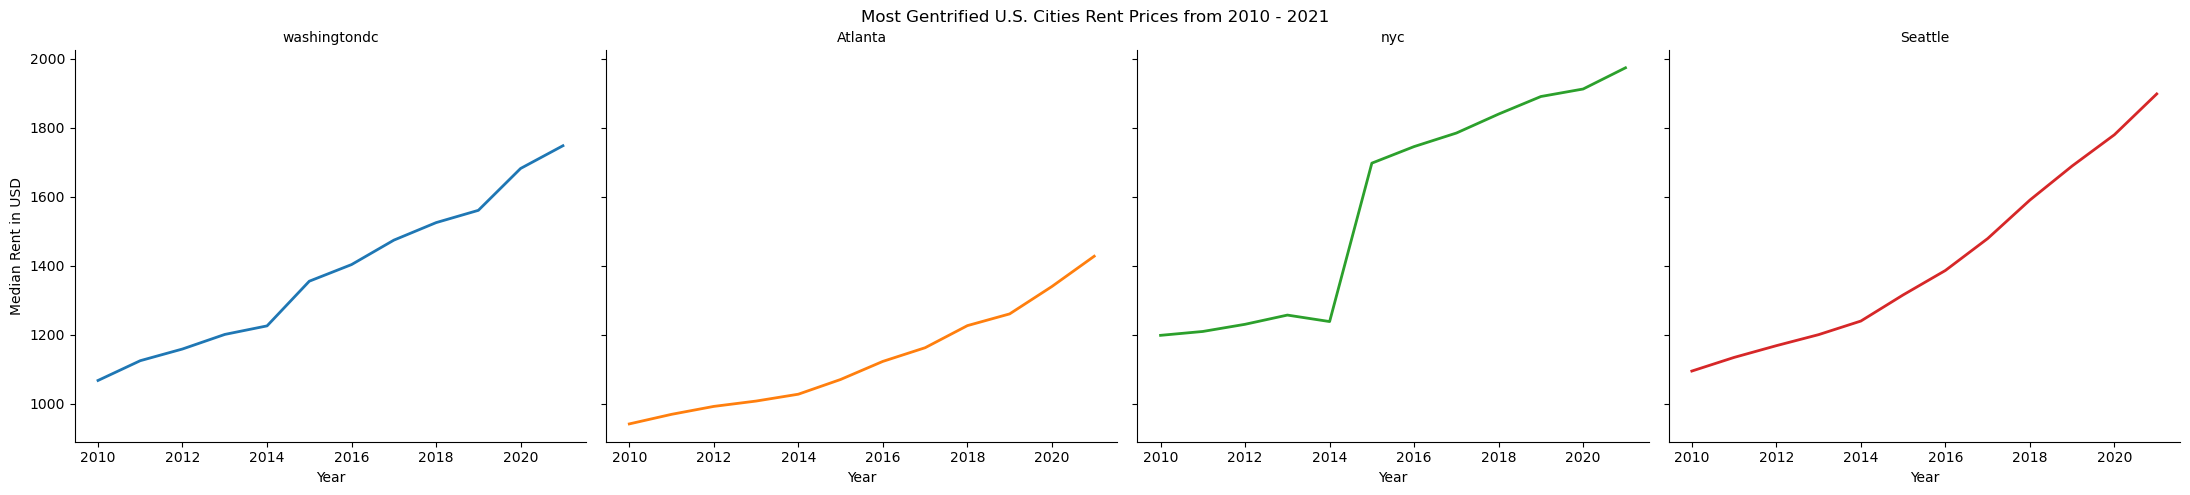

In [29]:
city_mappings = {'District of Columbia': 'washingtondc',
                    'Fulton County': 'Atlanta',
                    'New York County': 'nyc',
                    'King County': 'Seattle'}

rent_dollars_df.loc[:, 'city'] = rent_dollars_df.loc[:, 'County'].map(city_mappings)

lineplots = sns.FacetGrid(rent_dollars_df,
                          col="city",
                          margin_titles = True,
                          hue="city",
                          col_wrap=4,
                          aspect=1.1,
                          col_order=['washingtondc', 'Atlanta', 'nyc', 'Seattle'],
                          height=5
                 )

lineplots.map(sns.lineplot,
              "Year",
              "Median Rent in USD",
              linewidth=2,
              errorbar = None
     )

lineplots.set_titles(col_template = "{col_name}")  # use this argument literally
        
lineplots.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
lineplots.fig.suptitle('Most Gentrified U.S. Cities Rent Prices from 2010 - 2021', fontdict={'size':25})


In [1]:
"""json_wa = req_wa.json()
geo_wa = gpd.GeoDataFrame.from_features((json_wa))
merged_wa = geo_wa.merge(walk_rent,
                          how = 'left',
                          left_on = 'GEOID',
                          right_on='GEOID')


hover_cols = [
               'Median Rent in USD'
              ]

json_ny = req_ny.json()
geo_ny = gpd.GeoDataFrame.from_features((json_ny))
merged_ny = geo_ny.merge(walk_rent,
                          how = 'left',
                          left_on = 'GEOID',
                          right_on='GEOID')

json_ga = req_ga.json()
geo_ga = gpd.GeoDataFrame.from_features((json_ga))
merged_ga = geo_ga.merge(walk_rent,
                          how = 'left',
                          left_on = 'GEOID',
                          right_on='GEOID')

json_dc = req_dc.json()
geo_dc = gpd.GeoDataFrame.from_features((json_dc))
merged_dc = geo_dc.merge(walk_rent,
                          how = 'left',
                          left_on = 'GEOID',
                          right_on='GEOID')

px.choropleth(merged_wa,
               geojson=json_wa,
               locations='GEOID',
               color='Median Rent in USD',
               featureidkey="properties.GEOID",
               scope="usa",
               center={'lat':38.8938005,'lon':-77.1579293},
               hover_data = hover_cols,
               fitbounds="locations",
               height=450,
               width = 700,
               title = "Median Rent in Seattle, Washington Census Tracts")"""

'json_wa = req_wa.json()\ngeo_wa = gpd.GeoDataFrame.from_features((json_wa))\nmerged_wa = geo_wa.merge(walk_rent,\n                          how = \'left\',\n                          left_on = \'GEOID\',\n                          right_on=\'GEOID\')\n\n\nhover_cols = [\n               \'Median Rent in USD\'\n              ]\n\njson_ny = req_ny.json()\ngeo_ny = gpd.GeoDataFrame.from_features((json_ny))\nmerged_ny = geo_ny.merge(walk_rent,\n                          how = \'left\',\n                          left_on = \'GEOID\',\n                          right_on=\'GEOID\')\n\njson_ga = req_ga.json()\ngeo_ga = gpd.GeoDataFrame.from_features((json_ga))\nmerged_ga = geo_ga.merge(walk_rent,\n                          how = \'left\',\n                          left_on = \'GEOID\',\n                          right_on=\'GEOID\')\n\njson_dc = req_dc.json()\ngeo_dc = gpd.GeoDataFrame.from_features((json_dc))\nmerged_dc = geo_dc.merge(walk_rent,\n                          how = \'left\',\n    

In [2]:
"""px.choropleth(merged_ny,
               geojson=json_ny,
               locations='GEOID',
               color='Median Rent in USD',
               featureidkey="properties.GEOID",
               scope="usa",
               center={'lat':38.8938005,'lon':-77.1579293},
               hover_data = hover_cols,
               fitbounds="locations",
               height=450,
               width = 700,
               title = "Median Rent in New York, New York Census Tracts")"""

'px.choropleth(merged_ny,\n               geojson=json_ny,\n               locations=\'GEOID\',\n               color=\'Median Rent in USD\',\n               featureidkey="properties.GEOID",\n               scope="usa",\n               center={\'lat\':38.8938005,\'lon\':-77.1579293},\n               hover_data = hover_cols,\n               fitbounds="locations",\n               height=450,\n               width = 700,\n               title = "Median Rent in New York, New York Census Tracts")'

In [3]:
"""px.choropleth(merged_ga,
               geojson=json_ga,
               locations='GEOID',
               color='Median Rent in USD',
               featureidkey="properties.GEOID",
               scope="usa",
               center={'lat':38.8938005,'lon':-77.1579293},
               hover_data = hover_cols,
               fitbounds="locations",
               height=450,
               width = 700,
               title = "Median Rent in Atlanta, Georgia Census Tracts")"""

'px.choropleth(merged_ga,\n               geojson=json_ga,\n               locations=\'GEOID\',\n               color=\'Median Rent in USD\',\n               featureidkey="properties.GEOID",\n               scope="usa",\n               center={\'lat\':38.8938005,\'lon\':-77.1579293},\n               hover_data = hover_cols,\n               fitbounds="locations",\n               height=450,\n               width = 700,\n               title = "Median Rent in Atlanta, Georgia Census Tracts")'

In [4]:
"""px.choropleth(merged_dc,
               geojson=json_dc,
               locations='GEOID',
               color='Median Rent in USD',
               featureidkey="properties.GEOID",
               scope="usa",
               center={'lat':38.8938005,'lon':-77.1579293},
               hover_data = hover_cols,
               fitbounds="locations",
               height=450,
               width = 700,
               title = "Median Rent in Washington, D.C. Census Tracts")
"""

'px.choropleth(merged_dc,\n               geojson=json_dc,\n               locations=\'GEOID\',\n               color=\'Median Rent in USD\',\n               featureidkey="properties.GEOID",\n               scope="usa",\n               center={\'lat\':38.8938005,\'lon\':-77.1579293},\n               hover_data = hover_cols,\n               fitbounds="locations",\n               height=450,\n               width = 700,\n               title = "Median Rent in Washington, D.C. Census Tracts")\n'

In [5]:
"""sent_df = pd.read_csv(data_dir / "nlp_reddit_df.csv")
sent_df_raw = sent_df.copy(deep=True)
sent_df.loc[:, 'sentiment_label'] = sent_df.loc[:, 'sentiment'].apply(lambda x: x[2:-2])
sent_df.loc[:, 'renting'] = (sent_df['title'].fillna('').str.lower() + sent_df['selftext'].fillna('').str.lower()).str.contains('rent|house|housing')
sent_df = sent_df.rename({'renting': 'Post Mentions Housing'}, axis = 'columns')
sent_df = sent_df.loc[sent_df.sentiment_label.fillna('') != '',  : ]
grouped_df = sent_df.groupby(['subreddit', 'Post Mentions Housing', 'sentiment_label']).size().reset_index(name = 'count')

# turn into percentage
grouped_df['percentage'] = grouped_df['count'] / grouped_df.groupby(['Post Mentions Housing', 'subreddit'])['count'].transform('sum')

fig = px.bar(
    grouped_df,
    x='Post Mentions Housing',
    y='percentage',
    color='sentiment_label',
    category_orders = {'sentiment_label': ['neg', 'pos', 'neutral']},
    facet_col='subreddit',
    title='Stacked Normalized Bar Plot',
    labels={'percentage': '% of Reddit Posts'},
    facet_col_spacing=0
)

# Show the figure
fig.show()
"""

'sent_df = pd.read_csv(data_dir / "nlp_reddit_df.csv")\nsent_df_raw = sent_df.copy(deep=True)\nsent_df.loc[:, \'sentiment_label\'] = sent_df.loc[:, \'sentiment\'].apply(lambda x: x[2:-2])\nsent_df.loc[:, \'renting\'] = (sent_df[\'title\'].fillna(\'\').str.lower() + sent_df[\'selftext\'].fillna(\'\').str.lower()).str.contains(\'rent|house|housing\')\nsent_df = sent_df.rename({\'renting\': \'Post Mentions Housing\'}, axis = \'columns\')\nsent_df = sent_df.loc[sent_df.sentiment_label.fillna(\'\') != \'\',  : ]\ngrouped_df = sent_df.groupby([\'subreddit\', \'Post Mentions Housing\', \'sentiment_label\']).size().reset_index(name = \'count\')\n\n# turn into percentage\ngrouped_df[\'percentage\'] = grouped_df[\'count\'] / grouped_df.groupby([\'Post Mentions Housing\', \'subreddit\'])[\'count\'].transform(\'sum\')\n\nfig = px.bar(\n    grouped_df,\n    x=\'Post Mentions Housing\',\n    y=\'percentage\',\n    color=\'sentiment_label\',\n    category_orders = {\'sentiment_label\': [\'neg\', \'po